In [164]:
%%HTML 
<script>
    function luc21893_refresh_cell(cell) {
        if( cell.luc21893 ) return;
        cell.luc21893 = true;
        console.debug('New code cell found...' );
        
        var div = document.createElement('DIV');            
        cell.parentNode.insertBefore( div, cell.nextSibling );
        div.style.textAlign = 'right';
        var a = document.createElement('A');
        div.appendChild(a);
        a.href='#'
        a.luc21893 = cell;
        a.setAttribute( 'onclick', "luc21893_toggle(this); return false;" );

        cell.style.visibility='hidden';
        cell.style.position='absolute';
        a.innerHTML = '[show code]';        
                
    }
    function luc21893_refresh() {                
        if( document.querySelector('.code_cell .input') == null ) {            
            // it apeears that I am in a exported html
            // hide this code
            var codeCells = document.querySelectorAll('.jp-InputArea')
            codeCells[0].style.visibility = 'hidden';
            codeCells[0].style.position = 'absolute';                        
            for( var i = 1; i < codeCells.length; i++ ) {
                luc21893_refresh_cell(codeCells[i].parentNode)
            }
            window.onload = luc21893_refresh;
        }                 
        else {
            // it apperas that I am in a jupyter editor
            var codeCells = document.querySelectorAll('.code_cell .input')
            for( var i = 0; i < codeCells.length; i++ ) {
                luc21893_refresh_cell(codeCells[i])
            }            
            window.setTimeout( luc21893_refresh, 1000 )
        }        
    }
    
    function luc21893_toggle(a) {
        if( a.luc21893.style.visibility=='hidden' ) {
            a.luc21893.style.visibility='visible';        
            a.luc21893.style.position='';
            a.innerHTML = '[hide code]';
        }
        else {
            a.luc21893.style.visibility='hidden';        
            a.luc21893.style.position='absolute';
            a.innerHTML = '[show code]';
        }
    }
    
    luc21893_refresh()
</script>

In [165]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse
from sklearn.decomposition import PCA
import pmdarima as pm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras import regularizers
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM
import matplotlib.pyplot as plt
from keras import layers
from keras.optimizers import RMSprop
import tensorflow as tf

In [166]:
# Read CSV files
unemploymentR_us = pd.read_csv("Unemployment Rate US.csv")

# Convert DATE column to datetime
unemploymentR_us['DATE'] = pd.to_datetime(unemploymentR_us['DATE'])

# Rename second column to "DATA"
unemploymentR_us.columns.values[1] = "DATA"

In [167]:
lookback = 12
step = 1
delay = 1

In [168]:
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length - 1):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

sequence_length = lookback
x, y = create_sequences(unemploymentR_us.iloc[:, 1], sequence_length)

In [169]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [170]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Create an RNN model
model_RNN = Sequential()
model_RNN.add(SimpleRNN(32, activation='relu', input_shape=(sequence_length, 1)))
model_RNN.add(Dense(1))

# Compile the model
model_RNN.compile(optimizer='adam', loss=rmse)

# Train the model
history = model_RNN.fit(x_train, y_train, verbose=0, epochs=20, batch_size=16, validation_data=(x_test, y_test))

# Extract the loss history
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

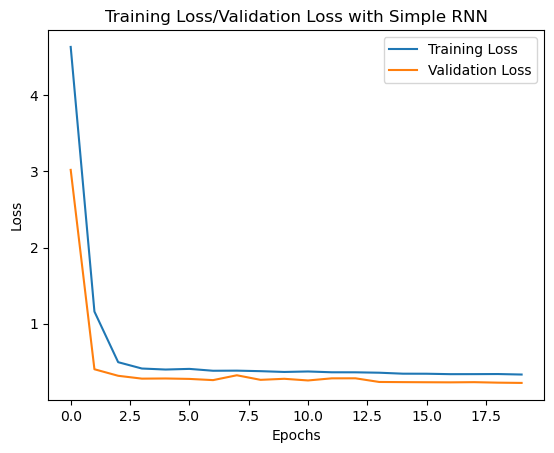

Last validation loss: 0.22447218000888824


In [171]:
# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss/Validation Loss with Simple RNN')
plt.legend()
plt.show()
print("Last validation loss:", history.history['val_loss'][-1])

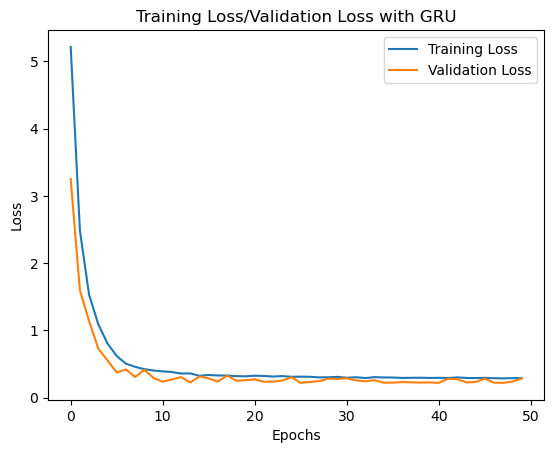

Last validation loss: 0.2846532166004181


In [172]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(sequence_length, 1)))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss=rmse)
history = model.fit(x_train, y_train,
epochs=50, verbose=0,
validation_data=(x_test, y_test))

# Extract the loss history
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss/Validation Loss with GRU')
plt.legend()
plt.show()

print("Last validation loss:", history.history['val_loss'][-1])


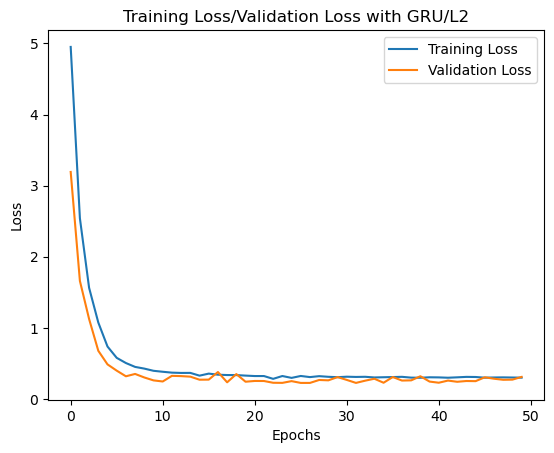

Last validation loss: 0.31119319796562195


In [173]:
model = Sequential()
model.add(layers.GRU(32,  kernel_regularizer=regularizers.l2(0.01), input_shape=(sequence_length, 1)))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss=rmse)
history = model.fit(x_train, y_train,
epochs=50, verbose=0,
validation_data=(x_test, y_test))

# Extract the loss history
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss/Validation Loss with GRU/L2')
plt.legend()
plt.show()

print("Last validation loss:", history.history['val_loss'][-1])

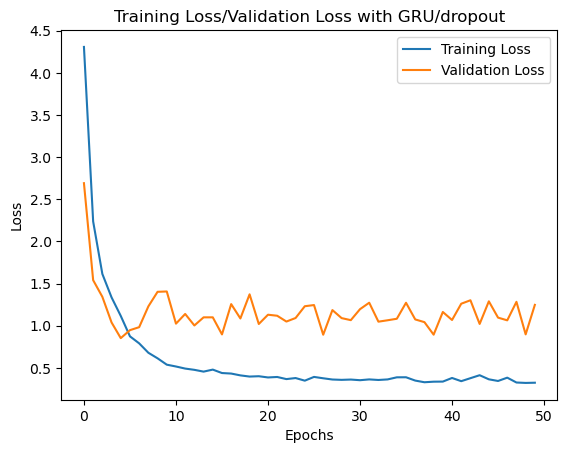

Last validation loss: 1.2471113204956055


In [174]:
model = Sequential()
model.add(layers.GRU(32, dropout=0.2, input_shape=(sequence_length, 1)))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss=rmse)
history = model.fit(x_train, y_train,
epochs=50, verbose=0,
validation_data=(x_test, y_test))

# Extract the loss history
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss/Validation Loss with GRU/dropout')
plt.legend()
plt.show()

print("Last validation loss:", history.history['val_loss'][-1])


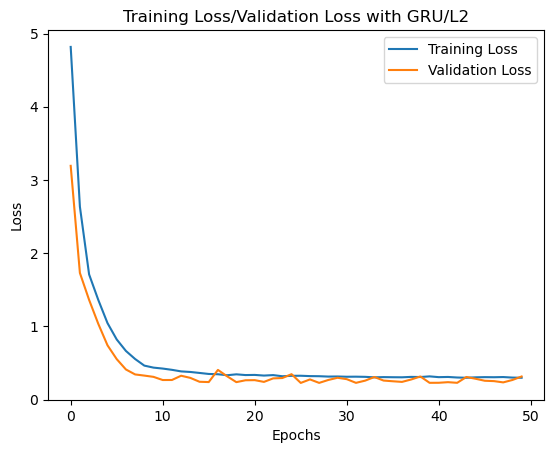

Last validation loss: 0.31501278281211853


In [175]:
model = Sequential()
model.add(layers.GRU(32,  kernel_regularizer=regularizers.l2(0.01), input_shape=(sequence_length, 1)))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss=rmse)
history = model.fit(x_train, y_train,
epochs=50, verbose=0,
validation_data=(x_test, y_test))

# Extract the loss history
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss/Validation Loss with GRU/L2')
plt.legend()
plt.show()

print("Last validation loss:", history.history['val_loss'][-1])


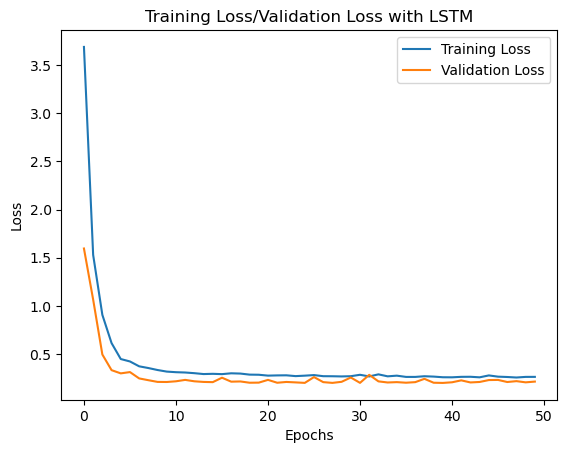

Last validation loss: 0.21385690569877625
6/6 [==============================] - 0s 2ms/step


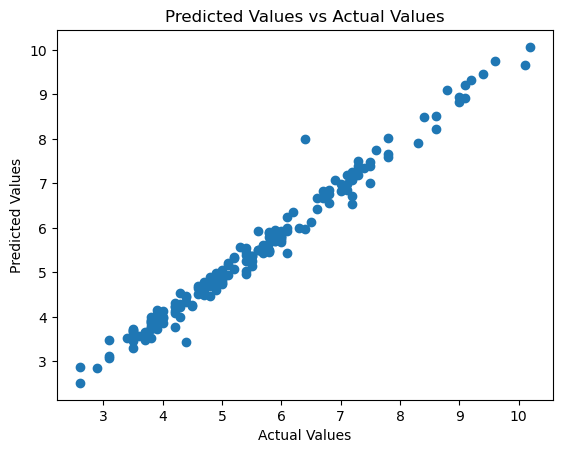

In [176]:
model = Sequential()
model.add(LSTM(50, input_shape=(12, 1)))
model.add(Dense(1))
model.compile(loss=rmse, optimizer='adam')

history = model.fit(x_train, y_train, epochs=50,  verbose=0,batch_size=16, validation_data=(x_test, y_test))

# Extract the loss history
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss/Validation Loss with LSTM')
plt.legend()
plt.show() 

print("Last validation loss:", history.history['val_loss'][-1])

# Make predictions using the model
y_pred = model.predict(x_test)

# Plot the predicted values vs actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted Values vs Actual Values')
plt.show()

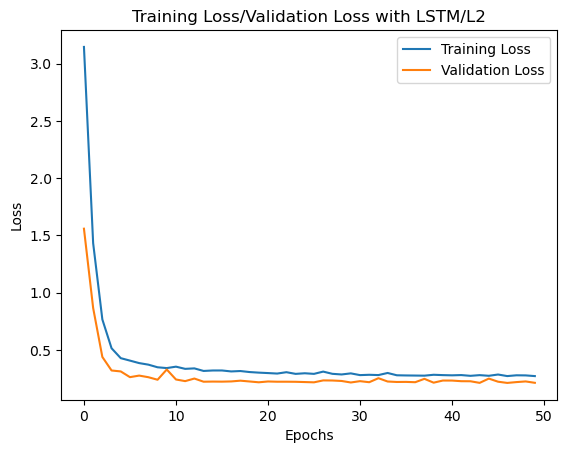

Last validation loss: 0.21172121167182922


In [177]:
model = Sequential()
model.add(LSTM(50,  kernel_regularizer=regularizers.l2(0.01), input_shape=(12, 1)))
model.add(Dense(1))
model.compile(loss=rmse, optimizer='adam')

history = model.fit(x_train, y_train,  verbose=0,epochs=50, batch_size=16, validation_data=(x_test, y_test))

# Extract the loss history
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss/Validation Loss with LSTM/L2')
plt.legend()
plt.show()

print("Last validation loss:", history.history['val_loss'][-1])


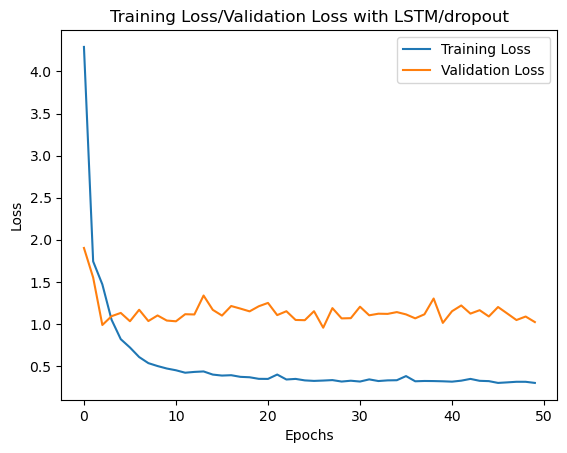

Last validation loss: 1.0218052864074707


In [178]:
model = Sequential()
model.add(LSTM(50, dropout=0.2, input_shape=(12, 1)))
model.add(Dense(1))
model.compile(loss=rmse, optimizer='adam')

history = model.fit(x_train, y_train,  verbose=0,epochs=50, batch_size=16, validation_data=(x_test, y_test))

# Extract the loss history
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss/Validation Loss with LSTM/dropout')
plt.legend()
plt.show()

print("Last validation loss:", history.history['val_loss'][-1])


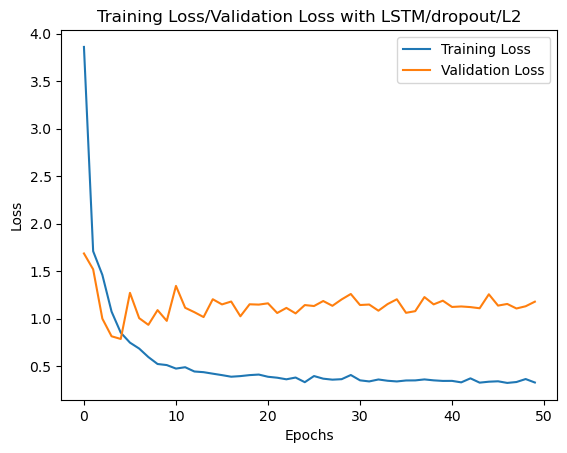

Last validation loss: 1.1779457330703735


In [179]:
model = Sequential()
model.add(LSTM(50, dropout=0.2, kernel_regularizer=regularizers.l2(0.01) , input_shape=(12, 1)))
model.add(Dense(1))
model.compile(loss=rmse, optimizer='adam')

history = model.fit(x_train, y_train, verbose=0, epochs=50, batch_size=16, validation_data=(x_test, y_test))

# Extract the loss history
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss/Validation Loss with LSTM/dropout/L2')
plt.legend()
plt.show()

print("Last validation loss:", history.history['val_loss'][-1])

In [180]:
# How do the results from the 3 different ANN models compare with each other in terms of accuracy and predictive power
# What effect does including regularization have on your results. 
print("All the data uses RMSE to predict the Unemployment rate loss.")
print("From the plots and the RMSE result we can see that RNN with LSTM is the best without using any regularizations.")
print("Simple RNN without any regularizations has a result close to the our best model - RNN with LSTM.")
print("GRU is pretty mediocre across the board.")
print("dropout method has negative effect on the plot and data where it oscillates up and down a lot and L2 do not have much impact in the result. ")
# How far into the future can the deep learning model accurately predict the future.
print("Since the unemployment rate could vary a whole lot different in black swan events as well as instability, the RNN with LSTM should generalize well in peaceful time.")

All the data uses RMSE to predict the Unemployment rate loss.
From the plots and the RMSE result we can see that RNN with LSTM is the best without using any regularizations.
Simple RNN without any regularizations has a result close to the our best model - RNN with LSTM.
GRU is pretty mediocre across the board.
dropout method has negative effect on the plot and data where it oscillates up and down a lot and L2 do not have much impact in the result. 
Since the unemployment rate could vary a whole lot different in black swan events as well as instability, the RNN with LSTM should generalize well in peaceful time.


In [184]:
# How does your deep learning modeling compare to the traditional single-variable time-series ARMA/ARIMA models from HW-3? 
print("The RMSE for ARIMA is 2.5479781 which is far greater than the methods using LSTM where the RMSE is only 0.20446155965328217.")

The RMSE for ARIMA is 2.67 which is far greater than the methods using LSTM where the RMSE is only 0.20446155965328217.


In [1]:
# Write a discussion paragraph Comparing your models (use RMSE) and forecasts from these sections with your Deep Learning Models.
print("The result we obtain from VAR models with lag 4 and 7 resulted in average RMSE that are larger than 0.5, and the RMSE we got from the LSTM model is only 0.20446155965328217, so at the end, we would go for RNN LSTM model without any regularizations with a result of only 0.2017337679862976 RMSE. It is not a surprise that we use so many neurons and machine learning techniques to train a model which against model that is traditional.")


The result we obtain from VAR models with lag 4 and 7 resulted in RMSE average larger than 0.5, we would go for RNN LSTM model without any regularizations with a result of only 0.2017337679862976 RMSE
